In [1]:
!pip install -U segmentation-models

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install gradio

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import cv2
from PIL import Image
import numpy as np
import segmentation_models as sm
from matplotlib import pyplot as plt
import random

2023-09-30 10:18:38.131897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 10:18:38.266223: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-30 10:18:38.677215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/emma/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-09-30 10:18:38.677260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7';

Segmentation Models: using `keras` framework.


In [4]:
from keras import backend as K
from keras.models import load_model

In [5]:
import gradio as gr

/home/emma/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten*y_pred_flatten)
  final_coef_value = (intersection + 1.0) /(K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [7]:
weights = [0.166,0.166,0.166,0.166,0.166,0.166]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss= sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

In [8]:
satellite_model = load_model('./satellite_segmentation_80.h5', 
                         custom_objects=({'dice_loss_plus_1focal_loss':total_loss,
                                          'jaccard_coef':jaccard_coef}))

2023-09-30 10:18:40.450782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-30 10:18:40.482905: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-30 10:18:40.483158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-30 10:18:40.483648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
#satellite_model.get_config()

In [10]:
image = Image.open('./content/image 43.jpg')
image = image.resize((256,256))
image = np.array(image)
image = np.expand_dims(image,0)

In [11]:
prediction = satellite_model.predict(image)

2023-09-30 10:18:47.027609: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


1/1 [==============================] - 1s 1s/step


2023-09-30 10:18:47.499653: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [12]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

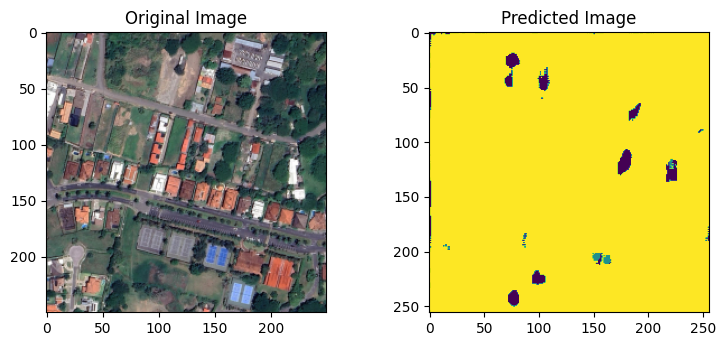

In [13]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('./content/image 43.jpg'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [14]:
def process_input_image(image_source):  
  image = np.expand_dims(image_source, 0)

  prediction = satellite_model.predict(image)

  predicted_image = np.argmax(prediction, axis=3)
  predicted_image = predicted_image[0,:,:]
  
  return 'Predicted Masked Image', predicted_image *50

In [15]:
my_app = gr.Blocks()

In [16]:
with my_app:
    gr.Markdown("Statellite Image Segmentation Application UI with Gradio")
    with gr.Tabs():
        with gr.TabItem("Select your image"):
            with gr.Row():
                with gr.Column():
                    img_source = gr.Image(label="Please select source Image", shape=(256, 256))
                    source_image_loader = gr.Button("Load above Image")
                with gr.Column():
                    output_label = gr.Label(label="Image Info")
                    img_output = gr.Image(label="Image Output")
            source_image_loader.click(
                process_input_image,
                [
                    img_source
                ],
                [
                    output_label,
                    img_output
                ]
            )

In [17]:
my_app.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/home/emma/.local/lib/python3.10/site-packages/gradio/routes.py", line 516, in predict
    output = await route_utils.call_process_api(
  File "/home/emma/.local/lib/python3.10/site-packages/gradio/route_utils.py", line 219, in call_process_api
    output = await app.get_blocks().process_api(
  File "/home/emma/.local/lib/python3.10/site-packages/gradio/blocks.py", line 1437, in process_api
    result = await self.call_function(
  File "/home/emma/.local/lib/python3.10/site-packages/gradio/blocks.py", line 1109, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/home/emma/.local/lib/python3.10/site-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/home/emma/.local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/home/emma/.local/lib/python3.10/site-packages/anyio/_backend

1/1 [==============================] - 0s 22ms/step
